<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Рекомендация-тарифов" data-toc-modified-id="Рекомендация-тарифов-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Рекомендация тарифов</a></span><ul class="toc-item"><li><span><a href="#Импортируем-все-необдходимое" data-toc-modified-id="Импортируем-все-необдходимое-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импортируем все необдходимое</a></span></li><li><span><a href="#Откроем-и-изучим-файл" data-toc-modified-id="Откроем-и-изучим-файл-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Откроем и изучим файл</a></span><ul class="toc-item"><li><span><a href="#Проверим-типы-данных" data-toc-modified-id="Проверим-типы-данных-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Проверим типы данных</a></span><ul class="toc-item"><li><span><a href="#Результаты-проверки" data-toc-modified-id="Результаты-проверки-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Результаты проверки</a></span></li></ul></li><li><span><a href="#Проверим--дубликаты" data-toc-modified-id="Проверим--дубликаты-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Проверим  дубликаты</a></span><ul class="toc-item"><li><span><a href="#Результаты-проверки" data-toc-modified-id="Результаты-проверки-1.2.2.1"><span class="toc-item-num">1.2.2.1&nbsp;&nbsp;</span>Результаты проверки</a></span></li></ul></li><li><span><a href="#Проверка-на-корректность-наименований-столбцов" data-toc-modified-id="Проверка-на-корректность-наименований-столбцов-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Проверка на корректность наименований столбцов</a></span><ul class="toc-item"><li><span><a href="#Результаты-проверки" data-toc-modified-id="Результаты-проверки-1.2.3.1"><span class="toc-item-num">1.2.3.1&nbsp;&nbsp;</span>Результаты проверки</a></span></li></ul></li><li><span><a href="#Проверим-значения-содержащиеся-в-столбцах" data-toc-modified-id="Проверим-значения-содержащиеся-в-столбцах-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Проверим значения содержащиеся в столбцах</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Разобьем-данные-на-выборки" data-toc-modified-id="Разобьем-данные-на-выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разобьем данные на выборки</a></span></li><li><span><a href="#Исследуем-модели" data-toc-modified-id="Исследуем-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследуем модели</a></span><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Проверьте-модель-на-тестовой-выборке" data-toc-modified-id="Проверьте-модель-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверьте модель на тестовой выборке</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Импортируем все необдходимое

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tqdm import tqdm
import matplotlib.pyplot as plt
RANDOM_SEED = 42

In [36]:
from pathlib import Path
p = Path("datasets/users_behavior.csv")
p.absolute()




WindowsPath('C:/Users/etsn/PycharmProjects/DataScienceLessons/task1_mobile/datasets/users_behavior.csv')

##  Откроем и изучим файл

In [37]:
frame = pd.read_csv('datasets/users_behavior.csv')

In [38]:
frame.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


### Проверим типы данных

In [39]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


#### Результаты проверки 
Изменим тип поля messages на int, потому что дробных сообщений быть не может

In [40]:
frame['messages']=frame['messages'].astype("int")

### Проверим  дубликаты

In [41]:
frame.duplicated().sum()

0

#### Результаты проверки 
Дубликатов не найдено

### Проверка на корректность наименований столбцов

In [42]:
frame.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

#### Результаты проверки 
Имена столбцов заданы корректно

### Проверим значения содержащиеся в столбцах

In [43]:
frame.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


### Вывод

1. Пропущенных значений нет
1. Типы столбцов в порядке
1. Дубликатов нет

# Разобьем данные на выборки

Разделим данные на целевой столбец и матрицу признаков

In [44]:
design_matrix = frame.loc[:,~frame.columns.isin(["is_ultra"])]
target_vector = frame["is_ultra"]

Так как у нас нет скрытой тестовой выборки - сделаем свою

In [10]:
(design_matrix_train,
 design_matrix_test,
 target_vector_train,
 target_vector_test) = train_test_split(design_matrix,
                                        target_vector,
                                        test_size = 0.33,
                                        random_state = RANDOM_SEED
                                       )
1

1

In [12]:
target_vector_train

57      1
1338    0
2509    0
2356    0
2691    0
       ..
1095    0
1130    0
1294    0
860     0
3174    0
Name: is_ultra, Length: 2153, dtype: int64

Теперь разделим тестовую выборку на тестовую и валидационную

In [13]:
(design_matrix_valid,
 design_matrix_test,
 target_vector_valid,
 target_vector_test) = train_test_split(design_matrix_test,
                                        target_vector_test,
                                        test_size = 0.5,
                                        random_state = RANDOM_SEED
                                       )

#  Исследуем модели

## Random Forest

In [ ]:
best_RF = None
best_accuracy_RF = 0
best_est_RF = 0
best_depth_RF = 0
exit = False
est = 5
parameters = []
for est in tqdm(range(2,52)):
    for depth in range(2,25):
        RF = RandomForestClassifier(random_state = RANDOM_SEED,n_estimators = est, max_depth = depth)
        RF.fit(design_matrix_train,target_vector_train)
        prediction_valid_RF = RF.predict(design_matrix_valid)
        accuracy_RF = accuracy_score(prediction_valid_RF, target_vector_valid)
        parameters.append((est, depth, accuracy_RF))
        print(parameters[-1])
        if best_accuracy_RF < accuracy_RF:
            best_RF = RF
            best_depth_RF = depth
            best_est_RF = est
            best_accuracy_RF = accuracy_RF

In [46]:
best_depth_RF, best_est_RF

(17, 14)

## Decision Tree

In [15]:
best_DT = None
best_accuracy_DT = 0
best_depth_DT = 0
for depth in tqdm(range(2,50)):
    DT = DecisionTreeClassifier(random_state = RANDOM_SEED, max_depth = depth)
    DT.fit(design_matrix_train,target_vector_train)
    prediction_valid_DT = DT.predict(design_matrix_valid)
    accuracy_DT = accuracy_score(prediction_valid_DT, target_vector_valid)
    if best_accuracy_DT < accuracy_DT:
        best_DT = DT
        best_accuracy_DT = accuracy_DT
        best_depth_DT = depth

100%|██████████| 48/48 [00:02<00:00, 19.18it/s]


Text(0.5, 1.0, 'estimators')

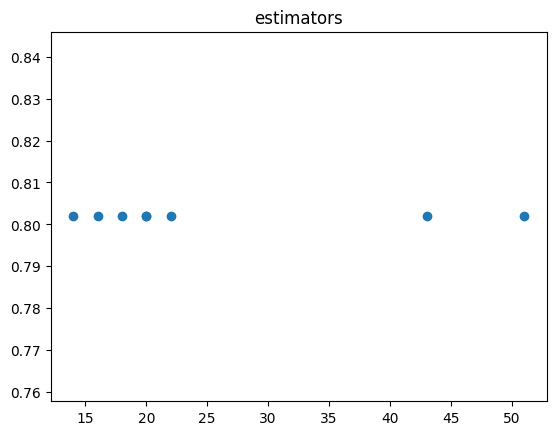

In [40]:
from matplotlib import pyplot as plt
plt.scatter([i[0] for i in parameters if i[2] >0.8=.785], [i[2] for i in parameters if i[2] >0.785])
plt.title("estimators")

Text(0.5, 1.0, 'depth')

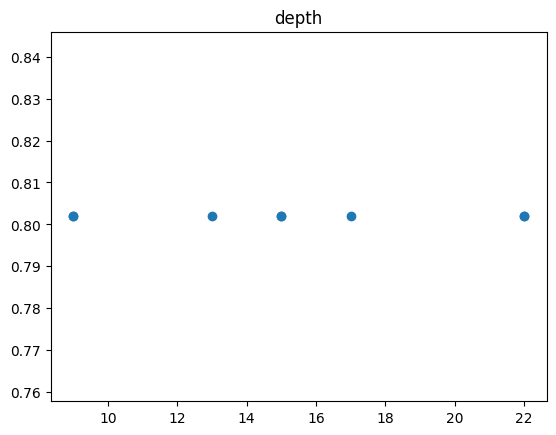

In [41]:
plt.scatter([i[1] for i in parameters if i[2] >0.785], [i[2] for i in parameters if i[2] >.785])
plt.title("depth")

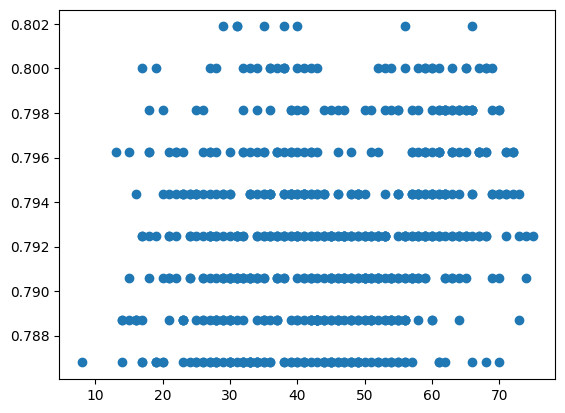

In [47]:
plt.scatter([i[1] + i[0] for i in parameters if i[2] >0.785], [i[2] for i in parameters if i[2] >0.785])

In [43]:
[i for i in parameters if i[2] > 0.8]

[(14, 17, 0.8018867924528302),
 (16, 22, 0.8018867924528302),
 (18, 22, 0.8018867924528302),
 (20, 9, 0.8018867924528302),
 (20, 15, 0.8018867924528302),
 (22, 9, 0.8018867924528302),
 (43, 13, 0.8018867924528302),
 (51, 15, 0.8018867924528302)]

In [53]:
RF = RandomForestClassifier(random_state = RANDOM_SEED,n_estimators = 42, max_depth = 90)
RF.fit(design_matrix_test,target_vector_test)


RandomForestClassifier(max_depth=90, n_estimators=42, random_state=42)

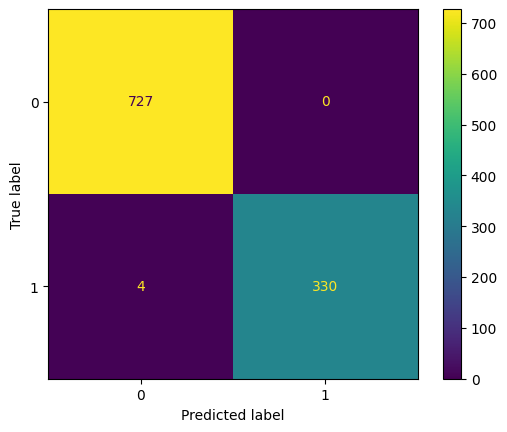

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(RF, design_matrix_test, target_vector_test)

In [32]:
my_df = pd.DataFrame.from_dict({"calls": [10], "minutes": [40], "messages": [3], "mb_used": [2400]})

In [33]:
RF.predict(my_df)

array([1], dtype=int64)

In [48]:
df_params = pd.DataFrame(parameters)


In [49]:
df_params.to_excel("svyzy.xlsx")

## LogisticRegression

In [16]:
LR = LogisticRegression(random_state = RANDOM_SEED,max_iter= 1000,tol=1e-5,solver = 'lbfgs' )
LR.fit(design_matrix_train,target_vector_train)
prediction_valid_LR = LR.predict(design_matrix_valid)
accuracy_LR = accuracy_score(prediction_valid_LR, target_vector_valid)

In [17]:
print(f"Logistic Regression: {accuracy_LR}")
print(f"Random Forest: {best_accuracy_RF}")
print(f"Decision Tree: {best_accuracy_DT}")

Logistic Regression: 0.7226415094339622
Random Forest: 0.7622641509433963
Decision Tree: 0.7849056603773585


## Вывод 

Основываясь на показателе точности, можно  прийти к выводу, что наиболее качественные результаты прогнозирует Random Forest

# Проверьте модель на тестовой выборке

In [18]:
prediction_test_LR = LR.predict(design_matrix_test)
prediction_test_RF = best_RF.predict(design_matrix_test)
prediction_test_DT = best_DT.predict(design_matrix_test)

In [45]:
custom_rf = RandomForestClassifier(random_state = RANDOM_SEED,n_estimators = 14, max_depth = 17)
custom_rf.fit(design_matrix_train,target_vector_train)
prediction = custom_rf.predict(design_matrix_test)
accuracy_score(prediction, target_vector_test)


0.807909604519774

In [19]:
accuracy_LR_test = accuracy_score(prediction_test_LR, target_vector_test)
accuracy_RF_test = accuracy_score(prediction_test_RF, target_vector_test)
accuracy_DT_test = accuracy_score(prediction_test_DT, target_vector_test)

In [20]:
print(f"Logistic Regression: {accuracy_LR_test}")
print(f"Random Forest: {accuracy_RF_test}")
print(f"Decision Tree: {accuracy_DT_test}")

Logistic Regression: 0.7608286252354048
Random Forest: 0.7984934086629002
Decision Tree: 0.7796610169491526


## Вывод

Наиболее адекватные предсказания делает Random Forest, это видно по точности предсказания на валидационной и на тестовой выборке
